In [1]:
## libraries
import pandas as pd
import json
import re
import warnings
import pickle
import jgraph
import collections
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch

from IPython.display import Markdown
warnings.filterwarnings('ignore')


## Political Discourse Network  

#### 1. Claim clusters and cleaned actor list 

In [2]:
with open("Pickles/clustered_claims_final3.pkl", 'rb') as f:
    ##                                  max_df,min_df,ngram_range
    ## claim_list,top6_cluster_features,0.2,   0.02,  (1,6)
    arr_text = pickle.load(f)
    claim_text = arr_text[0]
    claim_names = arr_text[1]

# with open("clean_actors_PolDis_v2.pkl", 'rb') as f:
#     actor = pickle.load(f)
with open("Pickles/supp_opp_final3.pkl", 'rb') as f:
    supp_opp = pickle.load(f)

#### 2. Timestamp list for time-lapse graph 

In [3]:
## gather trimestamps
claim_text_ian = open("Save/Claims_ian.txt").read()
claims_split_ian = claim_text_ian.split("\n\n#") 
# actor = []
# claims = []
timestamps_ian = []
count = 0
for c in claims_split_ian:
    txt = c.split("DATED: ")[-1]
    txt1 = txt.split("/")[0]+"/"+txt.split("/")[1]
#     txt = txt.replace(txt1,"")
    timestamps_ian.append(txt1)
    count+=1

In [4]:
## gather trimestamps
claim_text_ank = open("Save/Claims_ank.txt").read()
claims_split_ank = claim_text_ank.split("\n\n#") 
# actor = []
# claims = []
timestamps_ank = []
count = 0
for c in claims_split_ank:
    txt = c.split("DATED: ")[-1]
    txt1 = txt.split("/")[0]+"/"+txt.split("/")[1]
#     txt = txt.replace(txt1,"")
    timestamps_ank.append(txt1)
    count+=1

#### extracting all dates list

In [5]:
from datetime import datetime
# t = datetime.strptime(date_time_str, '%d/%m')


filename = open("4mFullData_Kyoto_filename_list.txt").read()
filename_split =filename.split()
dates = []
for f in filename_split:
    f = f.split("/")[1] 
    txt = f.split("_")[0:3][:-1]
    t = ("/").join(txt)
    dates.append(t)
#     print(t)


In [6]:
timestamps_ian_corr = []
for i in timestamps_ian:
    count = 0
    for j in range(0,len(dates)):
        if i == dates[j]:
            timestamps_ian_corr.append(dates[j+452])
            break

#### Clean the actors 

In [7]:
actor = []
for i in claim_text['actor']:
    i = i.replace("'","")
    actor.append(i)
claim_text['actor'] = actor
# print(claim_text['actor'])

In [8]:
# claims_split = claims_split_ank + claims_text_ian
timestamps = timestamps_ank + timestamps_ian_corr

#### Actor clustering 

In [9]:
## special curated list
act_stopwords = ['mr.','dr.','i','the','a','we','of','and','other ','at','his','number','some',
             'officials','department','programs','agency','coalition','leaders','organizations','expert'
            'groups','powerful','organization','institute','trade', 'industry','advisers','laboratories',
             'fund','policy','university','panel','treaty','union','view','dominant','senator']
tricky_words = ['president','administrations','countries']

## actor group clustering
act_count = 0
act_cluster = [-1]*len(actor)
cluster_no = 0

## regex-substituter for actor stopwords
replace_stopwords = re.compile('|'.join(map(re.escape, act_stopwords)))
act_cluster_keys = []
## searching for word by word exactness of actors
while True: ######################################################### SUPER_LOOP START
    ## stop words replaced, so checking not necessary
    a1 = (replace_stopwords.sub("",actor[act_count].lower())).split()       # [actor-1] to be checked with....
    sub_act_count = 0
    ## every super-loop restarts [actor-1] as a NEW CLUSTER
    act_cluster[act_count]=cluster_no
    
    ## looping through every actor till a cluster is formed
    while True:  ##------------------------------------------## sub_LOOP START
        ## stop words replaced, so checking not necessary
        a2 = (replace_stopwords.sub("",actor[sub_act_count].lower())).split()   # ...[actor-2] for semantic overlap

        ## proceeding only if [actor-2] is NOT CLUSTERED
        if(act_cluster[sub_act_count]==-1):                
                ## adding actors to clusters based on word exactness
                
                ## need two matches minimum per actor for actors with tricky words
                a_match = 1+ int(any(i in a1 for i in tricky_words) or any(i in a2 for i in tricky_words))
                                
                ## 1. checking if they are an exact match
                if("".join(a1) == "".join(a2)):         
                    act_cluster[sub_act_count] = cluster_no

                ## 2. checking for partial match except 'stopwords'
                else:
                    ## looping actor-1 with actor-2 for partial match
                    for i in a1:   #-----------------------------------------## actor-1 START
                        for j in a2:         #-----------------------------------------## actor-2 START
                            ## word by word exactness
                            if(i == j):
                                a_match-=1
                            ##baby-loop-1--------------------------------------## actor-2 END        
                        ##baby-loop-1--------------------------------------## actor-1 END
                        if(a_match<=0):
                            act_cluster[sub_act_count] = cluster_no
                            break
                                
        ## sub-loop count iterator ---------------------------## sub_LOOP END
        sub_act_count+=1
        ## sub-loop maker and breaker
        try:
            temp = actor[sub_act_count]
        except:
            break            
        while act_cluster[sub_act_count]!=-1:
            sub_act_count+=1
            if(sub_act_count==(len(actor)-1)):
                break
            

    act_cluster_keys.append(actor[act_count])        
    ## super-loop count iterator##################################### SUPER_LOOP END
    act_count+=1
    ## super-loop maker and breaker
    try:
        temp = actor[act_count]
    except:
        break
    while act_cluster[act_count]!=-1:
        act_count+=1
        if(act_count==(len(actor)-1)):
            break
    ## at every super loop, one cluster is formed
    cluster_no+=1
                    

In [10]:
## the colour pallete for the network
##          dark    -  colours     
claim_color_pallete = [0x490357 ,0x022055 ,0x194B00 ,0x410200 ,0x512402  ]
##                     black     increment
actor_color_pallete = [0xaaaaaa ,0x010a71  ]

In [11]:
## kMeans cluster keys
claim_text.keys()
# act_cluster

dict_keys(['actor', 'claims', 'cluster'])

In [12]:
## cluster counts
# act_cluster_counts = {str(i):act_cluster.count(i) for i in act_cluster}
# print(len(act_cluster_counts))
# print()
# claim_cluster_counts = {str(i):claim_text['cluster'].count(i) for i in claim_text['cluster']}
# print(len(claim_cluster_counts))
timestamps_counts = {str(i):timestamps.count(i) for i in timestamps}
print(timestamps_counts)

{'1995/01': 10, '1997/01': 1, '1997/02': 4, '1997/03': 11, '1997/06': 84, '1997/07': 23, '1997/08': 26, '1997/09': 36, '1997/10': 91, '2002/02': 2, '2002/03': 51, '2002/04': 45, '2002/06': 150, '2002/08': 16}


In [13]:
timestamps_counts.keys()

dict_keys(['1995/01', '1997/01', '1997/02', '1997/03', '1997/06', '1997/07', '1997/08', '1997/09', '1997/10', '2002/02', '2002/03', '2002/04', '2002/06', '2002/08'])

In [14]:
## discourse newtork graph
pol_dis_nw     =  {
                    'nodes':{},
                    'edges':{}
                    }
edge_subdict    = {'source': '', 'target': '', 'size': 0, 'color':0x000000}
node_subsubdict = {'color': 0x000000, 'size': 0.0}
claim_text['supp_opp'] = supp_opp 

#### Political Discourse graph of all actor and claim clusters

In [15]:
### for making the actor claim discourse network
def act_claim_graph(claim_text,act_cluster,actor,supp_opp,init,end):
    ## main vars
    act_cluster = act_cluster[init:end]
    actor = actor[init:end]
    cluster = claim_text['cluster'][init:end]
    supp_opp = supp_opp[init:end]
    
    ## cluster counts
    act_cluster_counts = {str(i):act_cluster.count(i) for i in act_cluster}
    claim_cluster_counts = {str(i):cluster.count(i) for i in cluster}

    col_dict = mcd.CSS4_COLORS
    col_keys = list(col_dict.keys())
#     print(claim_color_pallete)
    ## -1. timewise-graph creator

    ## 0. the jgraph 
    pol_dis_nw     =  {
                    'nodes':{},
                    'edges':{}
                    }
    ## 1. edge propertoes
    edge_size = {'+':1.5,'-':0.5}
    edge_col = {'+':0xFFAF03,'-':0xaaaaaa}
    
    ## 2. nodes
    ## a. actor nodes
    nodes = {}
    node_colours = {}
    
    act_col = actor_color_pallete[0]
    actXsize = (1/max(act_cluster_counts.values()))*1 
    a_count = 147
#     print(act_cluster_counts)
    
    for key in act_cluster_counts.keys():
        i = act_cluster_counts[key]
        i = 0.5+(actXsize*i)                        ## actor node size range(0.5,1.5)
        ## storing node clour for index
#         print(key)
        node_colours[key] = col_dict[col_keys[a_count]]
        hex_int = int(node_colours[key].replace("#","0x"), 16)
        new_int = hex_int + 0x200
        sub_node = {'color': hex(new_int),'size':i}
        nodes[key] = sub_node
#         act_col+=actor_color_pallete[1]
        a_count-=5
    #     break
    ## b. claim nodes
    # for colour, 'claim_color_pallete'
    claimXsize = (1/max(claim_cluster_counts.values()))*2.5
    c_count = 17 
    node_colours["ACTORS"] = '#FFFFFF'
    for key in claim_cluster_counts.keys():
        i = claim_cluster_counts[key]
        i = 1+(claimXsize*i)                           ## claim node size range(1,3.5)
        ## storing node clour for index
#         node_colours[] = "#"+str(hex(claim_color_pallete[int(key)]))
        node_colours['C'+key] = col_dict[col_keys[c_count]]
        hex_int = int(node_colours['C'+key].replace("#","0x"), 16)
        new_int = hex_int + 0x200
        sub_node = {'color': hex(new_int),'size':i}
        nodes['C'+key] = sub_node
#         act_col+=actor_color_pallete[1]
        c_count+=27
    #     break
    node_colours["CLAIMS"] = '#FFFFFF'
    pol_dis_nw['nodes'] = nodes
    
    
    ## 3. edges
    ## a. actor nodes
    edges = []
    for i in range(0,len(actor)):
        source = act_cluster[i]
        e_size = edge_size[supp_opp[i]]
        e_col = edge_col[supp_opp[i]]
        sub_edge = {'source': str(source), 'target': 'C'+str(cluster[i]), 'size': 1, 'color': e_col}
        edges.append(sub_edge)
    #     break
    pol_dis_nw['edges'] = edges
    
    # import json
    # print( json.dumps(pol_dis_nw))
    # edge_subdict
    return(pol_dis_nw,node_colours)

#### 1. Full Graph of entire network 

In [16]:
# jgraph.draw(act_claim_graph(claim_text,act_cluster,actor,supp_opp,0,-1))

#### 2. Month-wise timelapse of actor-claim network  

In [17]:
(claim_names)

[["'s", 'administration', 'approaches', 'country', 'environmental', 'nations'],
 ['climate', 'change', 'climate', 'scientific', 'observed', 'earth'],
 ['kyoto', 'protocol', 'kyoto', 'treaty', 'kyoto', 'according'],
 ['emissions', 'greenhouse', 'reduce', 'gases', 'cuts', 'carbon'],
 ['warming', 'global', 'global', 'problem', 'threat', 'environment']]

In [18]:
#############################
## Cluster Representatives:
    # claim_names
    # act_cluster_keys
#############################

# key =  in list(timestamps_counts.keys())[2:]:
def graph_per_time(claim_text,act_cluster,actor,key,init,end):
#     end += (timestamps_counts[key])
    nw, col_ix = act_claim_graph(claim_text,act_cluster,actor,supp_opp,init,end)
    index = list(col_ix.keys())
    ## date printing
#     print(index)
    display (Markdown('<span style="color:#000000">'+key+'</span>'))
    ########################################################
    overlap = {name for name in mcd.CSS4_COLORS
               if "xkcd:" + name in mcd.XKCD_COLORS}
    
    fig = plt.figure(figsize=[3.8, 6])
    AX = fig.add_axes([0, 0, 1, 1])
#     index = "Stuff"
    i = 0
    for j, n in enumerate(sorted(overlap, reverse=True)):
        weight = "bold"
        try:
            kolor = col_ix[index[i]]
            key  = index[i]
        except:
            break
        cn = kolor
#         print(cn)
        r2 = mpatch.Rectangle((0, j), 1, 1, color=cn)
        
        if(key!="ACTORS" and key!="CLAIMS" ):
            if(key[0]=='C'):
#                 print(key)
                txt = AX.text(2, j+.5, key+": "+"-".join(claim_names[int(key[1:])]), va='center', fontsize=8,
                      weight=weight)
            else:
                txt = AX.text(2, j+.5, key+": "+act_cluster_keys[int(key)], va='center', fontsize=8,
                      weight=weight)
        else:
            txt = AX.text(2, j+.5, key, va='top', fontsize=10,
                      weight=weight)
    
        AX.add_patch(r2)
        AX.axhline(j, color=cn)
        i+=1
            
    AX.text(0.5, 1.5, ' ', ha='center', va='center')
    AX.set_xlim(0.5, 3)
    AX.set_ylim(0, j + 2)
    AX.axis('off')
    
    return(nw)

In [19]:
timestamps_counts

{'1995/01': 10,
 '1997/01': 1,
 '1997/02': 4,
 '1997/03': 11,
 '1997/06': 84,
 '1997/07': 23,
 '1997/08': 26,
 '1997/09': 36,
 '1997/10': 91,
 '2002/02': 2,
 '2002/03': 51,
 '2002/04': 45,
 '2002/06': 150,
 '2002/08': 16}

<span style="color:#000000">1997/09</span>

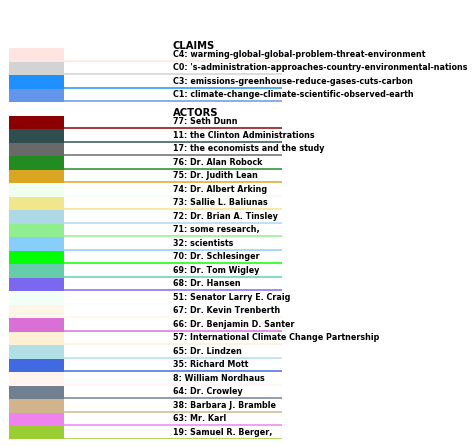

In [22]:
init = 0
end  = -1
n = 7
for k in list(timestamps_counts.keys())[n:]:
    init = sum(list(timestamps_counts.values())[:n])
    end = sum(list(timestamps_counts.values())[:n+1])
#     print(timestamps_counts[k])
#     print(type(k))
    g = graph_per_time(claim_text,act_cluster,actor,k,init,end)
    jgraph.draw(g)
    break


![Poltical Discourse graph 1](https://cdn.mathpix.com/snip/images/O2EKLh4k8jWGBAfnmEiNS5UrwBZmQ6Eaas2nF3WDSUc.original.fullsize.png)